## Simulate the sandpile model with 2 random neighbours

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

Define the sandpile model below

In [2]:
def sandpile_model(initial_state, max_value=1, yield_all=False, grain_add_method='random'):
    nx, ny = initial_state.shape
    state = initial_state.copy()

    # execute topplings (if any)
    while True:
        
        # Initialize placeholder for avalanche size
        avalanche_size = 0
        
        while True:
            
            # create a zero-padded copy of state so we don't
            # need to worry about the edges
            # CHECK THIS OUT
            state_padded = np.pad(state, 1, 'constant', constant_values=0)

            # Chech if excited sites are present
            is_above_threshold = state_padded > max_value

            if not np.any(is_above_threshold):
                break

            # Find the excited site
            i, j = np.where(is_above_threshold)
            
            # Remove grains from the excited site
            state_padded[i, j] -= 2
            
            # Assing sand randomly twice
            for _ in range(2):
                
                # Determine whether to move vertically or horizontally
                ver_ho = np.random.randint(0,2)
                
                # Determine the direction to move
                direction = 2*np.random.randint(0,2) - 1
                
                # Vertically
                if ver_ho == 0:
                    state_padded[i, j + direction] += 1
                    
                # Horizontally
                elif ver_ho == 1:
                    state_padded[i + direction, j] += 1

            # Add avalance number
            avalanche_size += np.count_nonzero(is_above_threshold)
            
            # Remove padding
            state = state_padded[1:-1, 1:-1]
            
            if yield_all:
                yield state, None

        # Add grains at random sites
        if grain_add_method == 'random':
            i, j = np.random.randint(nx), np.random.randint(ny)
        
        # Only add grains at the edge of the system
        elif grain_add_method == 'edge':
            
            ver_ho2 = np.random.randint(0,2)
            
            # Vertical
            if ver_ho2 == 0:
                
                # Either on the left or right
                j = nx*np.random.randint(0,2) - 1
                
                # Row number
                i = np.random.randint(nx)
                
            # Horizontal
            elif ver_ho2 == 1:
                
                # Either at the top or bottom
                i = ny*np.random.randint(0,2) - 1
                
                # Column number
                j = np.random.randint(ny)
            
        state[i, j] += 1
        
        yield state, avalanche_size

### Q1

*Implement the sandpile model on an $50 \times 50$ lattice and plot avalanche size as a function of time*

Run the system and record avalanche sizes

In [280]:
# Initialize an empty lattice
initial_state = np.zeros((25, 25), dtype=int)
state_generator = sandpile_model(initial_state, grain_add_method = 'random')

# Keep track of avalanche sizes
iterations = 5000
avalanches = []
av_grains = []

for state, avalanche_size in state_generator:
    if avalanche_size > 0:
        avalanches.append(avalanche_size)
        av_grains.append(np.average(state))

    if len(avalanches) > iterations-1:
        break

Plot the resulting time series of avalanche sizes

In [281]:
# Define x values for the plot
x_vals = range(iterations)

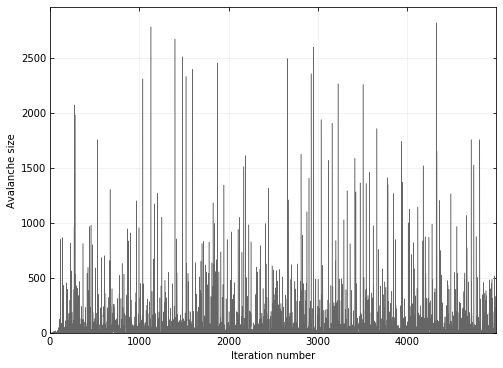

In [312]:
# Initialize the figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.plot(x_vals, avalanches, color = '0.4', linewidth = 0.5)

# Plot setting
ax.set_xlabel('Iteration number')
ax.set_ylabel('Avalanche size')
ax.set_xlim(x_vals[0], x_vals[-1])
ax.set_ylim(0)
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
plt.show()

Compute the average number of sand grains per site

In [283]:
print('The average number of sand grains per site is ' + str(np.average(state)))

The average number of sand grains per site is 0.7024


Could make a time series of the average number of grains as a function of time, to show steady state

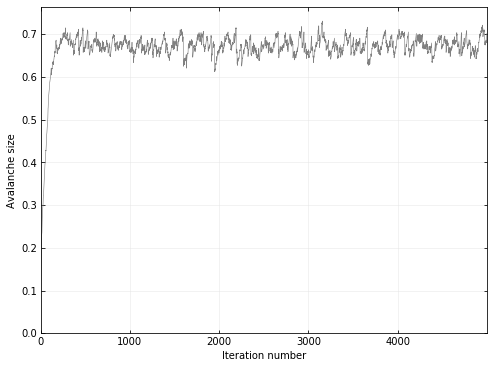

In [316]:
# Initialize the figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.plot(x_vals, av_grains, color = '0.5', linewidth = 0.6)

# Plot setting
ax.set_xlabel('Iteration number')
ax.set_ylabel('Avalanche size')
ax.set_xlim(x_vals[0], x_vals[-1])
ax.set_ylim(0)
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.show()

## Q.2

*Simulate the system for various sizes. Compute the steady state avalanche distribution for each system size and estimate the associated exponent*

In [71]:
# Initialize
sys_size = [25, 50, 100, 200]
iterations = 20000
n0 = 15000
avalanche_mat = np.zeros((len(sys_size), iterations - 15000)) # Rows correspond to system sizes, columns are avalance sizes after transient phase 
av_grain_mat = np.zeros(len(sys_size), iteration) # Keep track of average number of grains to find steady state

# Loop over system sizes
for i,L in enumerate(sys_size):

    # Initialize an empty lattice at given size
    initial_state = np.zeros((L, L), dtype=int)
    state_generator = sandpile_model(initial_state, grain_add_method = 'random')

    # Keep track of avalanche sizes
    avalanches = []
    av_grain = []

    for state, avalanche_size in state_generator:
        if avalanche_size > 0:
            avalanches.append(avalanche_size)
            av_grain.append(np.average(state))

        if len(avalanches) > iterations-1:
            break

    # Add avalanche distribution and grain number
    avalanche_mat[i,:] = avalanches[n0 : iterations]
    av_grain_mat[i,:] = av_grain[:]

Compute the distribution of avalanches 

In [207]:
# Generate bins
bin_nr = 30
bins = np.logspace(0,7,bin_nr)

# Initialize density matrix
density = np.zeros((len(avalanche_mat), bin_nr - 1))
s_vals = np.zeros(bin_nr - 1)

# Loop over system size
for i in range(len(avalanche_mat)):
    
    # Loop over bin values
    for j in range(bin_nr - 1):
    
        # Count occurences
        bol = (avalanche_mat[i,:] >= bins[j]) & (avalanche_mat[i,:] < bins[j+1])
        num = bol.sum()
        
        # Divide by bin length to generate density
        den = num / ((bins[j+1] - bins[j]) * len(avalanche_mat[i,:]))
        density[i,j] = den
        
        # Compte associated avalanche size as the mid point of each bin
        s_vals[j] = (bins[j] + bins[j+1]) / 2

Plot the resulting distribution in a log-log plot

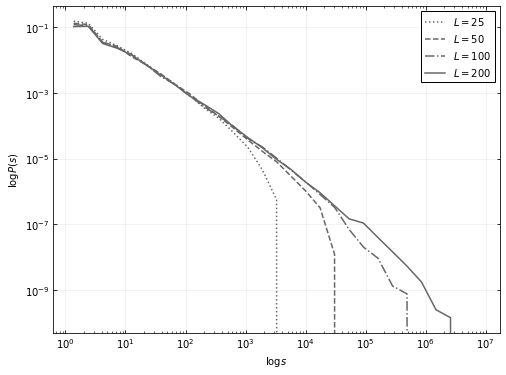

In [218]:
# Initialize the figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)

# Plot distributions
col = '0.4'
ax.plot(s_vals, density[0,:], color = col, linestyle = ':', label = r'$L = 25$')
ax.plot(s_vals, density[1,:], color = col, linestyle = '--', label = r'$L = 50$')
ax.plot(s_vals, density[2,:], color = col, linestyle = '-.', label = r'$L = 100$')
ax.plot(s_vals, density[3,:], color = col, linestyle = '-', label = r'$L = 200$')

# Settings
plt.xscale('log')
plt.yscale('log')

ax.set_xlabel(r'$\log s$')
ax.set_ylabel(r'$\log P(s)$')

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

Assume that the DGP for each plot is
$$ P(s) \propto \frac{1}{s^\tau} \exp \left( - \frac{s}{L^D} \right) $$
where $\tau$ and $D$ are to be estimated.

Try to estimate for the first system size using maximum likelihood

In [225]:
tau = np.zeros(len(avalanche_mat))

# Compute the maxiumum likelihood estimate
for i in range(len(tau)):
    
    tau[i] = len(avalanche_mat) / avalanche_mat[i,:].sum(axis=0) + 1
    print(tau[i])

1.0000107171659527
1.000002536191452
1.0000007503471293
1.0000001806398353


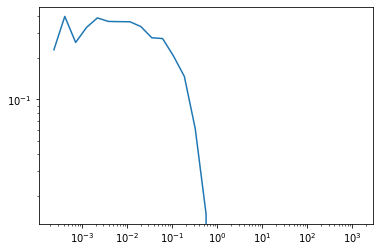

In [301]:
D = 2.69
expo = 2 - 2/D
L = 25

plt.plot(s_vals/(L**D), density[0,:]*s_vals**expo)

# plt.plot(s_vals, 1/s_vals**tau[0])
# plt.plot(s_vals, density[0,:])


plt.xscale('log')
plt.yscale('log')

## Q.3 ##